<a href="https://colab.research.google.com/github/YuxingW/deep_learning/blob/main/hw6/part_b_pytorchlighting_multilabel_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using Pytorch Lighting For Multilabel Image classification

###Introduction

The dataset has 27 categies of images

## Install required packages

In [ ]:
# Install requirements
!pip install -q numpy scikit-image scipy scikit-learn matplotlib tqdm tensorflow torch torchvision

In [ ]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile

##Load the image dataset

The original dataset can be found in <br />
https://github.com/spmallick/learnopencv.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! ls drive/MyDrive/nus_wide
! cp -r drive/MyDrive/nus_wide .

cats		   small_test.json    test.json
database.txt	   small_train.json   TrainImagelist.txt
NUS-WIDE-urls.txt  TestImagelist.txt  train.json


In [ ]:
! ls nus_wide

cats		   small_test.json    test.json
database.txt	   small_train.json   TrainImagelist.txt
NUS-WIDE-urls.txt  TestImagelist.txt  train.json


**Fix all seeds to make experiments reproducible**

In [ ]:
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

We use the .tar.gz archive from this(https://github.com/thuml/HashNet/tree/master/pytorch#datasets) 
github repository to speed up image loading(instead of loading it from Flickr).
Let's download and extract it. Also, copy our pre-processed annotations to the dataset folder. 

In [ ]:
img_folder = 'images'
if not os.path.exists(img_folder):
    def download_file_from_google_drive(id, destination):
        def get_confirm_token(response):
            for key, value in response.cookies.items():
                if key.startswith('download_warning'):
                    return value
            return None

        def save_response_content(response, destination):
            CHUNK_SIZE = 32768
            with open(destination, "wb") as f:
                for chunk in tqdm(response.iter_content(CHUNK_SIZE), desc='Downloading'):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)

        URL = "https://docs.google.com/uc?export=download"
        session = requests.Session()
        response = session.get(URL, params={'id': id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)
        save_response_content(response, destination)

    file_id = '0B7IzDz-4yH_HMFdiSE44R1lselE'
    path_to_tar_file = str(time.time()) + '.tar.gz'
    download_file_from_google_drive(file_id, path_to_tar_file)
    print('Extraction')
    with tarfile.open(path_to_tar_file) as tar_ref:
        tar_ref.extractall(os.path.dirname(img_folder))
    os.remove(path_to_tar_file)

copyfile('nus_wide/small_test.json', os.path.join(img_folder, 'small_test.json'))
copyfile('nus_wide/small_train.json', os.path.join(img_folder, 'small_train.json'))

'images/small_train.json'

Simple dataloader and label binarization, that is converting test labels into binary arrays of length 27 (number of classes) with 1 in places of applicable labels).

In [ ]:
class NusDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        self.data_path = data_path
        print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        img_path = os.path.join(self.data_path, self.imgs[item])
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

##Data visualization

loading images/small_test.json
loading images/small_train.json


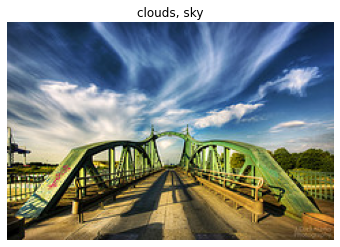

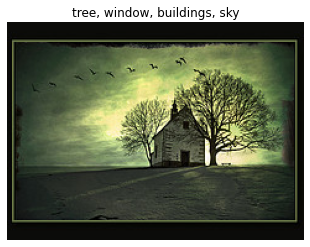

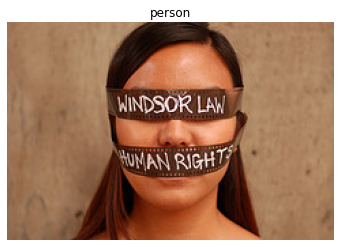

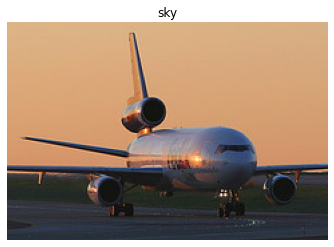

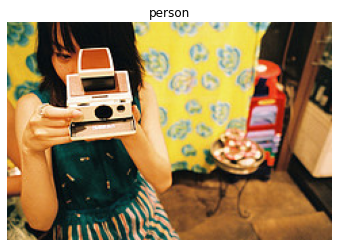

In [ ]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
dataset_val = NusDataset(img_folder, os.path.join(img_folder, 'small_test.json'), None)
dataset_train = NusDataset(img_folder, os.path.join(img_folder, 'small_train.json'), None)

# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample(*dataset_val[sample_id])

**Calculate label distribution for the entire dataset (train + test)**

Label distribution (count, class name): [(107, 'house'), (112, 'sun'), (114, 'birds'), (122, 'nighttime'), (128, 'valley'), (131, 'boats'), (157, 'mountain'), (157, 'tree'), (163, 'snow'), (167, 'beach'), (176, 'vehicle'), (188, 'rocks'), (237, 'reflection'), (266, 'sunset'), (286, 'road'), (290, 'flowers'), (389, 'ocean'), (395, 'lake'), (419, 'window'), (466, 'plants'), (518, 'buildings'), (661, 'grass'), (1065, 'water'), (1076, 'animal'), (1508, 'person'), (1709, 'clouds'), (2298, 'sky')]


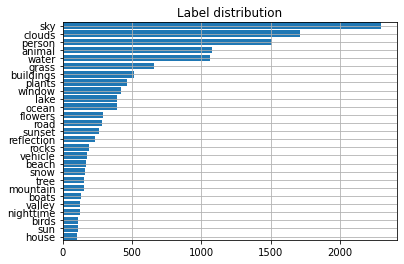

In [ ]:
samples = dataset_val.annos + dataset_train.annos
samples = np.array(samples)
with printoptions(precision=3, suppress=True):
    class_counts = np.sum(samples, axis=0)
    # Sort labels according to their frequency in the dataset.
    sorted_ids = np.array([i[0] for i in sorted(enumerate(class_counts), key=lambda x: x[1])], dtype=int)
    print('Label distribution (count, class name):', list(zip(class_counts[sorted_ids].astype(int), np.array(dataset_val.classes)[sorted_ids])))
    plt.barh(range(len(dataset_val.classes)), width=class_counts[sorted_ids])
    plt.yticks(range(len(dataset_val.classes)), np.array(dataset_val.classes)[sorted_ids])
    plt.gca().margins(y=0)
    plt.grid()
    plt.title('Label distribution')
    plt.show()

##Data transformation

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


# Test preprocessing
val_transform = transforms.Compose([
    transforms.Resize((5, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((5, 5)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                            shear=None, resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1315: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1329: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


##Construct pytorch lightning model

In [ ]:
! pip install -q pytorch_lightning
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F

*   3 channels input
*   Define loss function
*   Define optimizer
*   Define train validation and test data loaders
*   Define train and test steps

In [41]:
class smallAndSmartModel(pl.LightningModule):
    def __init__(self):
        super(smallAndSmartModel, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3,32,kernel_size=5),
            torch.nn.ReLU())
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,250,kernel_size=1),
            torch.nn.ReLU())
        self.dropout1=torch.nn.Dropout(0.25)
        self.fc1=torch.nn.Linear(250,54)
        self.dropout2=torch.nn.Dropout(0.08)
        self.fc2=torch.nn.Linear(54,27)
        self.criterion = nn.BCELoss()
    
    def train_dataloader(self):
        #This is an essential function
        batch_size = 32
        train_annotations = img_folder + '/small_train.json'
        train_dataset = NusDataset(img_folder, train_annotations, train_transform)
        num_workers = 5
        traindataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              drop_last=True)
        #Dividing into validation and training set
        print('len train dataset:', len(train_dataset))
        self.train_set, self.val_set= random_split(train_dataset,[4000,1000])
        
        return traindataloader
        
    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=128)

    def test_dataloader(self):
        test_annotations = img_folder + '/small_test.json'
        test_dataset = NusDataset(img_folder, test_annotations, val_transform)
        return DataLoader(test_dataset, batch_size=128)

    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.dropout1(x)
        x=torch.relu(self.fc1(x.view(x.size(0), -1)))
        x=F.leaky_relu(self.dropout2(x))
        
        return F.softmax(self.fc2(x))

    def configure_optimizers(self):
        # Essential fuction
        # we are using Adam optimizer for our model
        return torch.optim.Adam(self.parameters())

    def training_step(self,batch,batch_idx):
        #extracting input and output from the batch
        x,labels=batch
        
        #doing a forward pass
        pred=self.forward(x)
        
        #calculating the loss
        loss = self.criterion(pred, labels.type(torch.float))
        
        #logs
        logs={"train_loss": loss}
        
        output={
            #REQUIRED: It ie required for us to return "loss"
            "loss": loss,
            #optional for logging purposes
            "log": logs
        }
        
        return output

    def test_step(self,batch,batch_idx):
        #extracting input and output from the batch
        x,labels=batch
        
        #doing a forward pass
        pred=self.forward(x)
        
        #calculating the loss
        loss = self.criterion(pred, labels.type(torch.float))
        
        #logs
        logs={"test_loss": loss}
        
        output={
            #REQUIRED: It ie required for us to return "loss"
            "loss": loss,
            #optional for logging purposes
            "log": logs
        }
        
        return output

##Train lightning model

In [39]:
#using one gpu given to us by google colab for max 40 epochs
myTrainer=pl.Trainer(gpus=0, max_epochs=100)

model=smallAndSmartModel()
myTrainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name      | Type       | Params
-----------------------------------------
0 | layer1    | Sequential | 2.4 K 
1 | layer2    | Sequential | 8.2 K 
2 | dropout1  | Dropout    | 0     
3 | fc1       | Linear     | 13.6 K
4 | dropout2  | Dropout    | 0     
5 | fc2       | Linear     | 1.5 K 
6 | criterion | BCELoss    | 0     
-----------------------------------------
25.7 K    Trainable params
0         Non-trainable params
25.7 K    Total params
0.103     Total estimated model params size (MB)


loading images/small_train.json
len train dataset: 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

##Test/Evaluate lightning model

In [40]:
myTrainer.test(model)

loading images/small_test.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.21955686807632446}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'test_loss': 0.22657673060894012}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'test_loss': 0.23928984999656677}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'test_loss': 0.2597076892852783}
--------------------------------------------------------------------------------
DATALOADER:4 TEST RESULTS
{'test_loss': 0.27580153942108154}
--------------------------------------------------------------------------------
DATALOADER:5 TEST RESULTS
{'test_loss': 0.22168654203414917}
--------------------------------------------------------------------------------
DATALOADER:6 TEST RESULTS
{'test_loss': 0.23135899007320404}
------

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


[{'test_loss': 0.21955686807632446},
 {'test_loss': 0.22657673060894012},
 {'test_loss': 0.23928984999656677},
 {'test_loss': 0.2597076892852783},
 {'test_loss': 0.27580153942108154},
 {'test_loss': 0.22168654203414917},
 {'test_loss': 0.23135899007320404},
 {'test_loss': 0.24326661229133606},
 {}]

Overall the test loss is ~24%, not bad for 27 labels classification.